In [3]:
import sys

import os
import matplotlib.pyplot as plt 

sys.path.append(os.path.abspath('../src'))

In [4]:
import pandas as pd

In [103]:
df = pd.read_csv('../src/save/ER_intermediate_stdp/5/metrics.csv')

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.utils import resample

def bootstrap_analysis(data, n_bootstrap=5000, confidence=0.95):
    clean_data = np.array(data)[~np.isnan(data)]
    orig_mean = np.mean(clean_data)
    bootstrap_means = [np.mean(resample(clean_data, replace=True, n_samples=len(clean_data))) for _ in range(n_bootstrap)]
    alpha = (1 - confidence) / 2
    ci_lower = np.percentile(bootstrap_means, 100 * alpha)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha))
    return {
        'mean': orig_mean,
        'confidence_interval': (ci_lower, ci_upper),
        'contains_1': (ci_lower <= 1 <= ci_upper)
    }

def kendalls_w(data):
    # data: shape (n_subjects, n_conditions)
    ranks = stats.rankdata(data, axis=1)
    mean_ranks = np.mean(ranks, axis=0)
    S = np.sum((mean_ranks - np.mean(mean_ranks))**2)
    n, k = data.shape
    W = 12 * S / (n**2 * (k**3 - k))
    return W

def wilcoxon_effect_size(wilcoxon_result, n):
    # r = Z / sqrt(N)
    # scipy returns statistic, not Z, but for large samples statistic ~ Z
    # For small samples, you may want to use stats.norm.ppf for p-value
    # Here, we use the statistic as Z approximation
    return wilcoxon_result.statistic / np.sqrt(n)

def analyze_step_group(df):
    # Entropy columns
    entropy_pre = df['emsrs_h_A']
    entropy_post_immediate = df['emsrs_h_B']
    entropy_post_late = df['emsrs_h_C']
    # MI columns
    mi_AB = df['emsrs_mi_AB']
    mi_AC = df['emsrs_mi_AC']
    mi_AA = df['emsrs_mi_AA']

    # Entropy stats
    entropy_stats = {
        'pre_attack': {'mean': entropy_pre.mean(), 'std': entropy_pre.std(), 'min': entropy_pre.min(), 'max': entropy_pre.max()},
        'post_immediate': {'mean': entropy_post_immediate.mean(), 'std': entropy_post_immediate.std(), 'min': entropy_post_immediate.min(), 'max': entropy_post_immediate.max()},
        'post_late': {'mean': entropy_post_late.mean(), 'std': entropy_post_late.std(), 'min': entropy_post_late.min(), 'max': entropy_post_late.max()},
    }

    # MI stats
    mi_stats = {
        'AB': {'mean': mi_AB.mean(), 'std': mi_AB.std(), 'min': mi_AB.min(), 'max': mi_AB.max()},
        'AC': {'mean': mi_AC.mean(), 'std': mi_AC.std(), 'min': mi_AC.min(), 'max': mi_AC.max()},
        'AA': {'mean': mi_AA.mean(), 'std': mi_AA.std(), 'min': mi_AA.min(), 'max': mi_AA.max()},
    }

    # Statistical tests
    friedman_h_stat, friedman_h_p = stats.friedmanchisquare(entropy_pre, entropy_post_immediate, entropy_post_late)
    entropy_matrix = np.vstack([entropy_pre, entropy_post_immediate, entropy_post_late]).T
    kendall_w = kendalls_w(entropy_matrix)

    wilcoxon_h_ab = stats.wilcoxon(entropy_pre, entropy_post_immediate)
    wilcoxon_h_bc = stats.wilcoxon(entropy_post_immediate, entropy_post_late)
    wilcoxon_h_ac = stats.wilcoxon(entropy_pre, entropy_post_late)
    wilcoxon_mi_ab_ac = stats.wilcoxon(mi_AB, mi_AC)

    n_entropy = len(entropy_pre)
    n_mi = len(mi_AB)

    # Effect sizes
    effect_h_ab = wilcoxon_effect_size(wilcoxon_h_ab, n_entropy)
    effect_h_bc = wilcoxon_effect_size(wilcoxon_h_bc, n_entropy)
    effect_h_ac = wilcoxon_effect_size(wilcoxon_h_ac, n_entropy)
    effect_mi_ab_ac = wilcoxon_effect_size(wilcoxon_mi_ab_ac, n_mi)

    # Recovery ratios
    G_H = entropy_post_late - entropy_post_immediate
    L_H = entropy_pre - entropy_post_immediate
    R_H = np.where(L_H != 0, G_H / L_H, np.nan)

    G_mi = mi_AC - mi_AB
    L_mi = mi_AA - mi_AB
    R_mi = np.where(L_mi != 0, G_mi / L_mi, np.nan)

    # Bootstrap analysis
    R_H_results = bootstrap_analysis(R_H)
    R_mi_results = bootstrap_analysis(R_mi)
    G_H_results = bootstrap_analysis(G_H)
    L_H_results = bootstrap_analysis(L_H)
    G_mi_results = bootstrap_analysis(G_mi)
    L_mi_results = bootstrap_analysis(L_mi)

    return {
        'entropy_stats': entropy_stats,
        'mi_stats': mi_stats,
        'tests': {
            'friedman': {
                'statistic': friedman_h_stat,
                'p_value': friedman_h_p,
                'kendalls_w': kendall_w
            },
            'wilcoxon_pre_vs_immediate': {
                'statistic': wilcoxon_h_ab.statistic,
                'p_value': wilcoxon_h_ab.pvalue,
                'effect_size': effect_h_ab
            },
            'wilcoxon_immediate_vs_late': {
                'statistic': wilcoxon_h_bc.statistic,
                'p_value': wilcoxon_h_bc.pvalue,
                'effect_size': effect_h_bc
            },
            'wilcoxon_pre_vs_late': {
                'statistic': wilcoxon_h_ac.statistic,
                'p_value': wilcoxon_h_ac.pvalue,
                'effect_size': effect_h_ac
            },
            'wilcoxon_mi_AB_vs_AC': {
                'statistic': wilcoxon_mi_ab_ac.statistic,
                'p_value': wilcoxon_mi_ab_ac.pvalue,
                'effect_size': effect_mi_ab_ac
            },
        },
        'recovery_ratios': {
            'R_H': R_H_results,
            'R_mi': R_mi_results,
            "G_H": G_H_results,
            "L_H": L_H_results,
            "G_mi": G_mi_results,
            "L_mi": L_mi_results
        }
    }

In [107]:
master_df = pd.read_csv('../src/save/ER_intermediate_stdp/combined_metrics.csv')  # Assuming the CSV has a 'step' column

In [108]:
results_by_step = analyze_network_by_step(master_df)

In [109]:
results_by_step[1]["tests"]

{'friedman': {'statistic': np.float64(14.599999999999994),
  'p_value': np.float64(0.0006755387751938461),
  'kendalls_w': np.float64(0.007299999999999998)},
 'wilcoxon_pre_vs_immediate': {'statistic': np.float64(1.0),
  'p_value': np.float64(0.00390625),
  'effect_size': np.float64(0.31622776601683794)},
 'wilcoxon_immediate_vs_late': {'statistic': np.float64(3.0),
  'p_value': np.float64(0.009765625),
  'effect_size': np.float64(0.9486832980505138)},
 'wilcoxon_pre_vs_late': {'statistic': np.float64(0.0),
  'p_value': np.float64(0.001953125),
  'effect_size': np.float64(0.0)},
 'wilcoxon_mi_AB_vs_AC': {'statistic': np.float64(17.0),
  'p_value': np.float64(0.322265625),
  'effect_size': np.float64(5.375872022286244)}}

In [110]:
import pandas as pd

def recovery_ratios_to_df(results_by_step):
    """
    Convert recovery_ratios (mean and CI) from results_by_step to a DataFrame.
    """
    records = []
    for step, res in results_by_step.items():
        rr = res['recovery_ratios']
        records.append({
            'step': step,
            'R_H_mean': rr['R_H']['mean'],
            'R_H_CI_lower': rr['R_H']['confidence_interval'][0],
            'R_H_CI_upper': rr['R_H']['confidence_interval'][1],
            'R_mi_mean': rr['R_mi']['mean'],
            'R_mi_CI_lower': rr['R_mi']['confidence_interval'][0],
            'R_mi_CI_upper': rr['R_mi']['confidence_interval'][1],
        })
    return pd.DataFrame.from_records(records).sort_values('step').reset_index(drop=True)

# Example usage:
rr_df = recovery_ratios_to_df(results_by_step)
display(rr_df)

,step,R_H_mean,R_H_CI_lower,R_H_CI_upper,R_mi_mean,R_mi_CI_lower,R_mi_CI_upper
0,0,-2.420613,-6.997761,0.167889,-0.005278,-0.024953,0.012748
1,1,2.040107,-0.925313,7.468455,0.009187,-0.003128,0.021534
2,2,0.164975,-0.669732,0.986685,-0.007092,-0.023460,0.009256
3,3,0.924245,-0.242583,2.104443,-0.013038,-0.047798,0.019787
4,4,4.651457,0.149264,12.030199,-0.001616,-0.017095,0.014247
5,5,-0.826938,-2.904621,0.486099,0.000970,-0.018748,0.017999
6,6,-3.003186,-8.904329,0.723406,0.008193,-0.016130,0.030213
7,7,1.238944,-3.253597,5.419469,0.003157,-0.017395,0.024946
8,8,1.002871,0.311852,1.769117,0.003270,-0.009108,0.014996
9,9,-6.828913,-21.188537,0.800226,-0.000780,-0.016128,0.013575


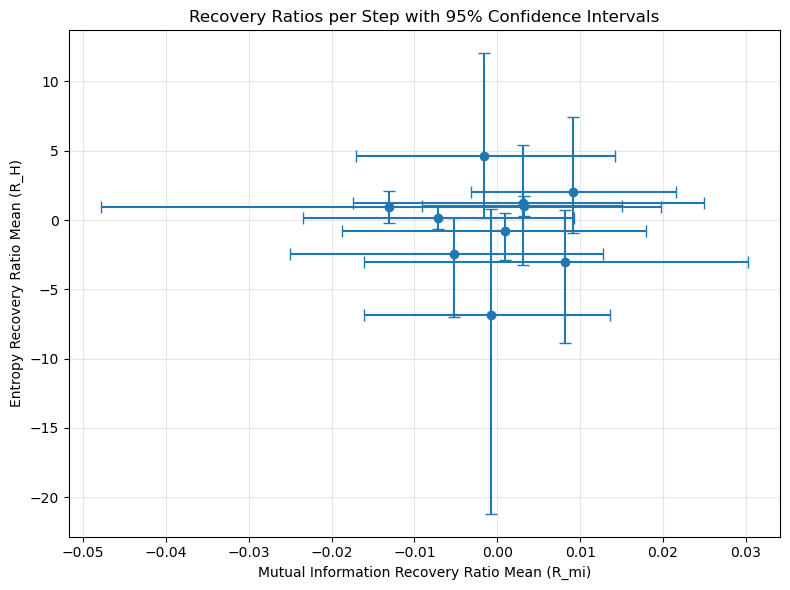

In [111]:
import matplotlib.pyplot as plt

def plot_recovery_ratios(rr_df):
    """
    Scatter plot of R_H_mean (y-axis) vs R_mi_mean (x-axis) with error bars for CIs.
    """
    plt.figure(figsize=(8, 6))
    # Plot error bars
    plt.errorbar(
        rr_df['R_mi_mean'], rr_df['R_H_mean'],
        xerr=[rr_df['R_mi_mean'] - rr_df['R_mi_CI_lower'], rr_df['R_mi_CI_upper'] - rr_df['R_mi_mean']],
        yerr=[rr_df['R_H_mean'] - rr_df['R_H_CI_lower'], rr_df['R_H_CI_upper'] - rr_df['R_H_mean']],
        fmt='o', capsize=4, label='Steps'
    )
    # Annotate each point with step number
    #for i, row in rr_df.iterrows():
    #    plt.annotate(str(row['step']), (row['R_mi_mean'], row['R_H_mean']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=9)
    plt.xlabel('Mutual Information Recovery Ratio Mean (R_mi)')
    plt.ylabel('Entropy Recovery Ratio Mean (R_H)')
    plt.title('Recovery Ratios per Step with 95% Confidence Intervals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# Example usage:
plot_recovery_ratios(rr_df)

In [112]:
rr_df['R_H_CI_width'] = rr_df['R_H_CI_upper'] - rr_df['R_H_CI_lower']
rr_df['R_mi_CI_width'] = rr_df['R_mi_CI_upper'] - rr_df['R_mi_CI_lower']

# Example: select points where both CI widths are below the median (or set your own threshold)
threshold_H = rr_df['R_H_CI_width'].median()
threshold_mi = rr_df['R_mi_CI_width'].median()

filtered_rr_df = rr_df[
    (rr_df['R_H_CI_width'] < threshold_H) &
    (rr_df['R_mi_CI_width'] < threshold_mi)
]

# Now filtered_rr_df contains only the steps with "tight" CIs
display(filtered_rr_df)

,step,R_H_mean,R_H_CI_lower,R_H_CI_upper,R_mi_mean,R_mi_CI_lower,R_mi_CI_upper,R_H_CI_width,R_mi_CI_width
2,2,0.164975,-0.669732,0.986685,-0.007092,-0.023460,0.009256,1.656417,0.032716
8,8,1.002871,0.311852,1.769117,0.003270,-0.009108,0.014996,1.457265,0.024104


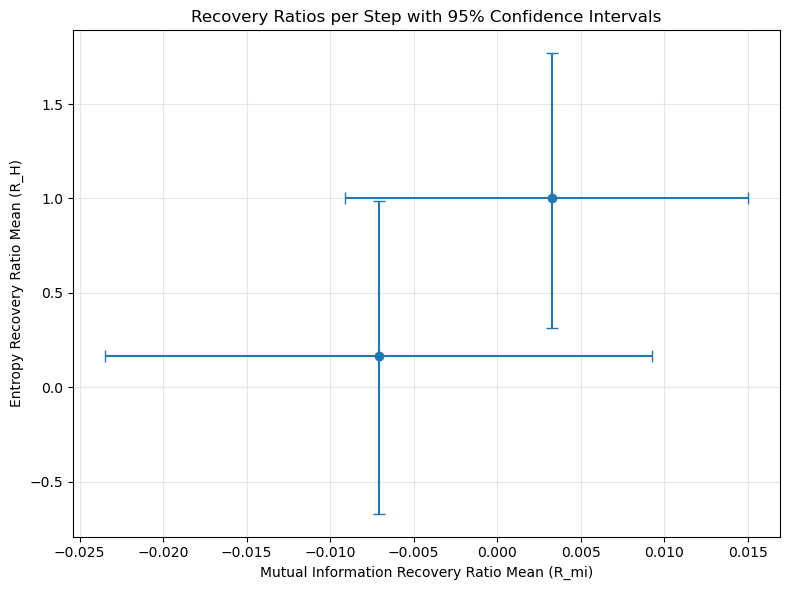

In [114]:
plot_recovery_ratios(filtered_rr_df)
